In [56]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F

Our second dataset consists of 300 samples from $y = sin(\pi x) + 0.2 cos(4\pi x) - 0.3x + \epsilon$, where $\epsilon \sim N(0, 0.25)$ and $x \sim N(5, 2.5)$.

In [57]:
np.random.seed(25)
# Create Wiggle Data
X = np.random.normal(loc=5,scale=2.5, size=300)
epsilon = np.random.normal(loc=0,scale=0.25,size=300)
y = np.sin(np.pi*X)+0.2*np.cos(4*np.pi*X)-0.3*X+epsilon


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


dataset = torch.utils.data.TensorDataset(torch.from_numpy(X.reshape(-1,1).astype(np.float32)).to(device), 
                                         torch.from_numpy(y.astype(np.float32)).to(device))

In [58]:
BATCH_SIZE = 32


# Initialize the dataloaders
dataloader = DataLoader(dataset=dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False)


# Check what we've created
print(f"DataLoader: {dataloader}" )
print(f"Length of train_dataloader: {len(dataloader)} batches of {BATCH_SIZE}...")

# Input to the model is (samples/batch size) x batch size
print(f"#Training datasamples/Batch Size: {len(X)}/{BATCH_SIZE}= {len(X)/BATCH_SIZE}")

DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x000001C4A81637F0>
Length of train_dataloader: 10 batches of 32...
#Training datasamples/Batch Size: 300/32= 9.375


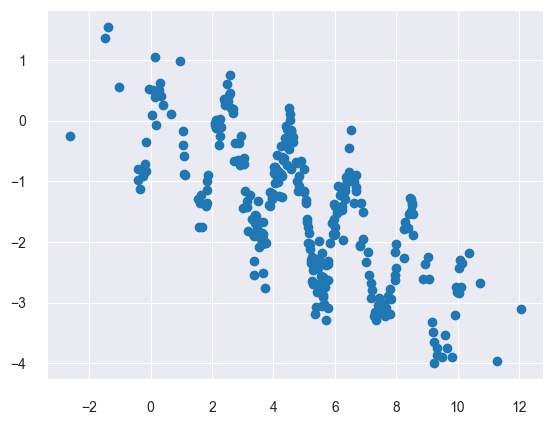

In [59]:
plt.scatter(X,y)

### Use Nicolas BatchEnsemble Code

In [12]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(1, 64)
        self.lin2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.silu(self.lin1(x))
        return self.lin2(x)

torch.manual_seed(0)
models = [Model() for i in range(16)]

(-5.0, 2.0)

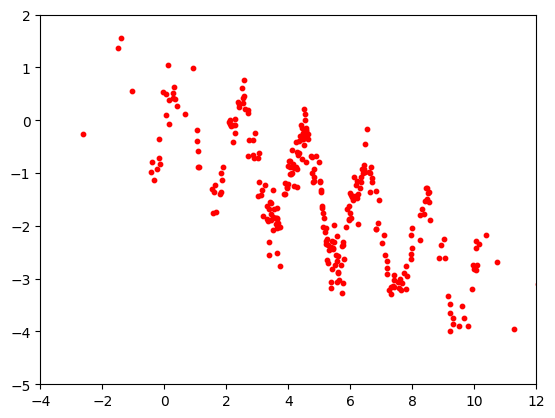

In [13]:
plt.scatter(X, y, c="red", s=10)
plt.xlim(-4, 12)
plt.ylim(-5, 2)

In [14]:
np.random.seed(0)
model_seed = np.random.randint(low=np.iinfo(np.int64).min, high=np.iinfo(np.int64).max, size=len(models), dtype=np.int64)

N = 300
batch_size = 32
n_steps = 20_000
logging_step = n_steps // 5
for i in range(len(models)):
    print(f"training model {i+1}:")
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(models[i].parameters())
    np.random.seed(1)
    for t in range(n_steps):
        idx = np.random.randint(0, N, batch_size)
        X_ = torch.tensor(X[idx, None]).float()
        y_ = torch.tensor(y[idx, None]).float()
    
        y_pred = models[i](X_)
        loss = criterion(y_pred, y_)
        #gen = torch.Generator().manual_seed(model_seed[i].item())
        #for param in models[i].parameters():
        #    param = param.ravel()
        #    prior = 1.0
        #    eps = torch.randn(param.shape[0], generator=gen) * np.sqrt(prior)
        #    loss += 1/prior * torch.dot(param - eps, param - eps)
        if t == 0 or t % logging_step == logging_step - 1:
            print(t, loss.item())
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

training model 1:
0 1.1210017204284668
3999 0.7350160479545593
7999 0.3734866976737976
11999 0.5464078187942505
15999 0.7578974962234497
19999 0.7561585307121277
training model 2:
0 5.142119407653809
3999 0.7356127500534058
7999 0.37470659613609314
11999 0.5413772463798523
15999 0.7574520707130432
19999 0.7554489374160767
training model 3:
0 0.8384015560150146
3999 0.7343636751174927
7999 0.37527239322662354
11999 0.5440043807029724
15999 0.7575684189796448
19999 0.7566498517990112
training model 4:
0 7.213838577270508
3999 0.7428820729255676
7999 0.3729371428489685
11999 0.5526331663131714
15999 0.7549254298210144
19999 0.762126088142395
training model 5:
0 20.3614559173584
3999 0.7352561950683594
7999 0.3730323016643524
11999 0.5451399087905884
15999 0.7554342746734619
19999 0.7590111494064331
training model 6:
0 0.9667825698852539
3999 0.7354320287704468
7999 0.376928448677063
11999 0.5438833236694336
15999 0.7566115260124207
19999 0.7569798231124878
training model 7:
0 1.0368444919

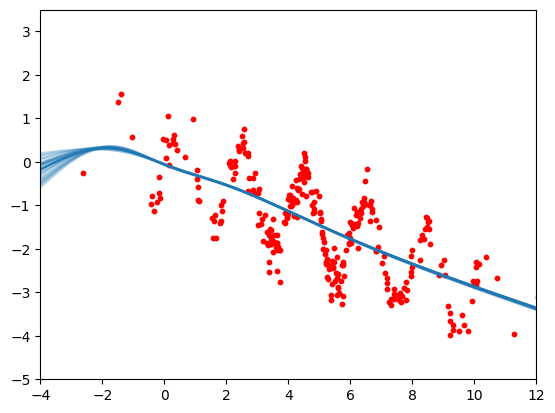

In [16]:
plt.figure()
X_pred = torch.linspace(-4, 12, 300)
y_pred = []
for i in range(len(models)):
    y_pred.append(
        models[i](X_pred.unsqueeze(-1))[:, 0]
    )
y_pred = torch.stack(y_pred, dim=-1)
for i in range(y_pred.shape[-1]):
    plt.plot(
        X_pred.detach().numpy(),
        y_pred[:, i].detach().numpy(),
        color="tab:blue",
        alpha=0.3
    )

y_mean = y_pred.mean(-1).detach().numpy()
y_std = y_pred.std(-1).detach().numpy()
plt.plot(
    X_pred.detach().numpy(),
    y_mean,
    color="tab:blue",
)
plt.fill_between(
    X_pred.detach().numpy(),
    y_mean - 2*y_std,
    y_mean + 2*y_std,
    color="tab:blue",
    alpha=0.2
)
plt.scatter(X, y, c="red", s=10)
plt.xlim(-4, 12)
plt.ylim(-5, 3.5)
plt.show()

### Test an Shallow NN Ensemble

In [76]:
class BaseNN(nn.Module):
        def __init__(self,
                     input_shape:int, 
                     hidden_units: int, 
                     output_shape: int):
            super().__init__()
            self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=1),
        )
        def forward(self, x):
            return self.layer_stack(x)

In [77]:
M = 10 # Number of ensemble members

# Initiate models
NaiveEnsemble = [BaseNN(input_shape=1,hidden_units=128,output_shape=1) for i in range(M)]

In [81]:
# Training Parameters
EPOCHS = 800
# Train each ensemble member
for model in NaiveEnsemble:
    # Initiate Loss function and Optimizer
    loss_function = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr= 0.005)
    model.to(device)
    # Conduct training
    for epoch in range(EPOCHS):
        # Training
        train_loss = 0
        # Add a loop to loop through the training batches
        for batch, (input, labels) in enumerate(dataloader):
            model.train()
            # 1. Perform forward pass
            y_pred = model(input) # Make prediction

            # 2. Calculate loss per batch
            loss = loss_function(y_pred.squeeze(), labels) # Calculate loss with MSE

            train_loss += loss.item() # Accumalate loss

            # 3. Optimizer zero grad
            optimizer.zero_grad() # Set the optimizer's gradients to zero

            # 4. Loss backward
            loss.backward()

            #5. Optimizer step
            optimizer.step()
        if epoch%50 == 0:
            print(f"Epoch: {epoch}\n-------")
            print("Loss:", train_loss / (batch + 1))  # Calculate and print average loss per epoch
        
    

Epoch: 0
-------
Loss: 0.48193240016698835
Epoch: 50
-------
Loss: 0.457293701171875
Epoch: 100
-------
Loss: 0.4535516262054443
Epoch: 150
-------
Loss: 0.44418713748455046
Epoch: 200
-------
Loss: 0.43911942690610883
Epoch: 250
-------
Loss: 0.43026424050331114
Epoch: 300
-------
Loss: 0.42997812330722807
Epoch: 350
-------
Loss: 0.42482817769050596
Epoch: 400
-------
Loss: 0.4196394354104996
Epoch: 450
-------
Loss: 0.4170404553413391
Epoch: 500
-------
Loss: 0.41389498114585876
Epoch: 550
-------
Loss: 0.4119978114962578
Epoch: 600
-------
Loss: 0.40680511891841886
Epoch: 650
-------
Loss: 0.4097892209887505
Epoch: 700
-------
Loss: 0.40487628877162934
Epoch: 750
-------
Loss: 0.40072720050811766
Epoch: 0
-------
Loss: 0.4866568028926849
Epoch: 50
-------
Loss: 0.45902687311172485
Epoch: 100
-------
Loss: 0.448058719933033
Epoch: 150
-------
Loss: 0.4385097950696945
Epoch: 200
-------
Loss: 0.428947776556015
Epoch: 250
-------
Loss: 0.4188989460468292
Epoch: 300
-------
Loss: 0.411

In [101]:
import numpy as np
from matplotlib import rc

rc('xtick.major', pad=12)
rc('ytick.major', pad=12)

import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import scale as mscale
from matplotlib import transforms as mtransforms

import pickle
import pandas as pd


def plot_predictive(x,y, trajectories, xs, mu=None, sigma=None, title=None):
    sns.set_style('darkgrid')
    palette = sns.color_palette('colorblind')
    
    blue = sns.color_palette()[0]
    red = sns.color_palette()[3]

    plt.figure(figsize=(9., 7.))
    
    plt.plot(x, y, "o", color=red, alpha=0.7, markeredgewidth=1., markeredgecolor="k")
    
    if mu is None:
        mu = np.mean(trajectories, axis=0)
    if sigma is None:
        sigma = np.std(trajectories, axis=0)

    plt.plot(xs, mu, "-", lw=2., color=blue)
    plt.plot(xs, mu-3 * sigma, "-", lw=0.75, color=blue)
    plt.plot(xs, mu+3 * sigma, "-", lw=0.75, color=blue)
    np.random.shuffle(trajectories)
    for traj in trajectories[:10]:
        plt.plot(xs, traj, "-", alpha=.5, color=blue, lw=1.)
        
    plt.fill_between(xs, mu-3*sigma, mu+3*sigma, alpha=0.35, color=blue)

    plt.xlim([np.min(xs), np.max(xs)])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if title:
        plt.title(title, fontsize=16)


In [93]:
# Plot code from drbayes github
z = np.linspace(-3, 13, 100).reshape(-1,1)
inp = torch.from_numpy(z.astype(np.float32)).to(device)

trajectories = []
for model in NaiveEnsemble:
    out = model(inp).cpu().detach().numpy().T
    trajectories.append(out)
trajectories = np.vstack(trajectories)
print(X.shape)
print(y.shape)
plot_predictive(X,y, trajectories, z.squeeze(), title="Naive Ensemble Solution")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

### Test Deep Ensemble
The previous Shallow NN ensemble members had too little complexity to capture the pattern in the data, we'll add some more layers and hidden units to try to find these patterns

In [83]:
class DeepNN(nn.Module):
        def __init__(self,
                     input_shape:int, 
                     hidden_units: int, 
                     output_shape: int):
            super().__init__()
            self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_shape,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,
                      out_features=1)
        )
        def forward(self, x):
            return self.layer_stack(x)

In [84]:
M = 10 # Number of ensemble members

# Initiate models
DeepNaiveEnsemble = [DeepNN(input_shape=1,hidden_units=128,output_shape=1) for i in range(M)]

In [85]:
# Training Parameters
EPOCHS = 800
# Train each ensemble member
for model in DeepNaiveEnsemble:
    # Initiate Loss function and Optimizer
    loss_function = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr= 0.005)
    model.to(device)
    # Conduct training
    for epoch in range(EPOCHS):
        # Training
        train_loss = 0
        # Add a loop to loop through the training batches
        for batch, (input, labels) in enumerate(dataloader):
            model.train()
            # 1. Perform forward pass
            y_pred = model(input) # Make prediction

            # 2. Calculate loss per batch
            loss = loss_function(y_pred.squeeze(), labels) # Calculate loss with MSE

            train_loss += loss.item() # Accumalate loss

            # 3. Optimizer zero grad
            optimizer.zero_grad() # Set the optimizer's gradients to zero

            # 4. Loss backward
            loss.backward()

            #5. Optimizer step
            optimizer.step()
        if epoch%50 == 0:
            print(f"Epoch: {epoch}\n-------")
            print("Loss:", train_loss / (batch + 1))  # Calculate and print average loss per epoch
        
    

Epoch: 0
-------
Loss: 2.1049440085887907
Epoch: 50
-------
Loss: 0.585848942399025
Epoch: 100
-------
Loss: 0.5395478069782257
Epoch: 150
-------
Loss: 0.5243763387203216
Epoch: 200
-------
Loss: 0.4473098233342171
Epoch: 250
-------
Loss: 0.3077779322862625
Epoch: 300
-------
Loss: 0.2859246268868446
Epoch: 350
-------
Loss: 0.21397054195404053
Epoch: 400
-------
Loss: 0.18787392228841782
Epoch: 450
-------
Loss: 0.15735582932829856
Epoch: 500
-------
Loss: 0.17461122572422028
Epoch: 550
-------
Loss: 0.1423831596970558
Epoch: 600
-------
Loss: 0.12498236894607544
Epoch: 650
-------
Loss: 0.11973562017083168
Epoch: 700
-------
Loss: 0.13743242993950844
Epoch: 750
-------
Loss: 0.12614489793777467
Epoch: 0
-------
Loss: 1.5238998293876649
Epoch: 50
-------
Loss: 0.5502453655004501
Epoch: 100
-------
Loss: 0.4828740328550339
Epoch: 150
-------
Loss: 0.35820361971855164
Epoch: 200
-------
Loss: 0.24501129388809204
Epoch: 250
-------
Loss: 0.24517674073576928
Epoch: 300
-------
Loss: 0.2

(300,)
(300,)


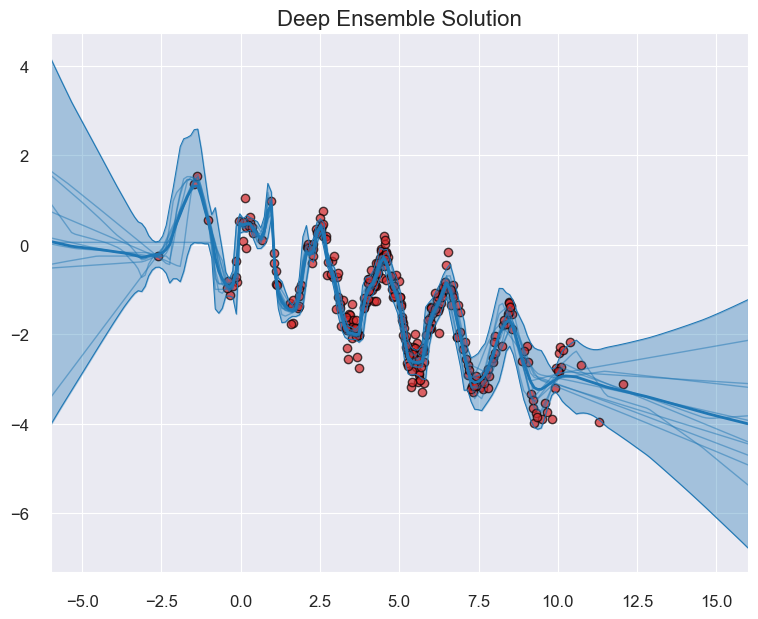

In [102]:
# Plot code from drbayes github
z = np.linspace(-6, 16, 200).reshape(-1,1)
inp = torch.from_numpy(z.astype(np.float32)).to(device)

trajectories = []
for model in DeepNaiveEnsemble:
    out = model(inp).cpu().detach().numpy().T
    trajectories.append(out)
trajectories = np.vstack(trajectories)
print(X.shape)
print(y.shape)
plot_predictive(X,y, trajectories, z.squeeze(), title="Deep Ensemble Solution")